In [1]:
# there no change change in the first several cells from last lecture


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from IPython.display import display, Math
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# ok biolerplate done, now we get to the action:


In [7]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')


In [8]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [9]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [10]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3416, grad_fn=<NegBackward0>)

In [11]:
#

In [184]:
# recommends to implement all the gradients 
# myself and come back
dloss = 1

# my way
dlogprobs_mask = torch.zeros(logprobs.shape)
dlogprobs_mask[range(n), Yb] = 1
dlogprobs = -1/n * dlogprobs_mask * dloss

#better way
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1/n
cmp('logprobs', dlogprobs, logprobs)

dprobs = 1.0 / probs * dlogprobs
display(Math(r'\frac{d}{dx}ln x = \frac{1}{x}'))
cmp('probs', dprobs, probs)

dcounts_sum_inv = counts * dprobs # for : probs = counts * counts_sum_inv
dcounts_sum_inv = torch.sum(dcounts_sum_inv, 1, keepdim=True)
#print(dcounts_sum_inv.shape)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

dcounts = counts_sum_inv * dprobs # for : probs = counts * counts_sum_inv
# this node has more connections, will be completed below


dcounts_sum = -counts_sum**-2 * dcounts_sum_inv
display(Math(r'\frac{d}{dx} \frac{1}{x} = -\frac{1}{x^{2}}'))
cmp('counts_sum', dcounts_sum, counts_sum)

#dcounts = dcounts_sum + dcounts
dcounts += torch.ones_like(counts)*dcounts_sum 
cmp('counts', dcounts, counts)

#dnorm_logits = norm_logits.exp() * dcounts
# we already calculated norm_logits.exp() for counts, so we can reuse it
dnorm_logits = counts * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

dlogit_maxes = -dnorm_logits.sum(1, keepdims=True) # my version was identical: -torch.sum(dnorm_logits, 1, keepdims=True) # first derivation step
cmp('logit_maxes', dlogit_maxes, logit_maxes)

dlogits = dnorm_logits.clone() # first derivation step
# second step my approach ( approx, true)
#derivating this step: logit_maxes = logits.max(1, keepdim=True).values
# dlogits_mask = torch.zeros_like(logits)
# dlogits_mask[range(n), logits.max(1, keepdim=True).indices] = 1
# dlogits += dlogits_mask * dlogit_maxes
# second step Andrej Karpathy
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
cmp('logits', dlogits, logits)

# logits = h @ W2 + b2 # output layer
dh =  dlogits @ W2.transpose(0, 1)
cmp('h', dh, h)

dW2 = h.transpose(0, 1) @ dlogits
cmp('W2', dW2, W2)

db2 = torch.sum(dlogits, 0)
cmp('b2', db2, b2)

#h = torch.tanh(hpreact)   # dtanh/dx = 1-tanh^2(x) 
display(Math(r'\frac{d}{dx}tanh(x) = 1 - tanh^2(x)'))
dhpreact = (1 - h**2) * dh
cmp('hpreact', dhpreact, hpreact)


#hpreact = bngain * bnraw + bnbias
dbngain = (dhpreact * bnraw).sum(0, keepdims=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdims=True)

cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)

# bnraw = bndiff * bnvar_inv
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdims=True)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

dbndiff  = bnvar_inv * dbnraw
# should broadcast successfully:  (torch.Size([32, 64]), torch.Size([1, 64]), torch.Size([32, 64]))

# bnvar_inv = (bnvar + 1e-5)**-0.5
dbnvar = -0.5*(bnvar + 1e-5)**-1.5 * dbnvar_inv
cmp('bnvar', dbnvar, bnvar)


# differentiating through the bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# Andrej says the paper on BN introduces a train-test mismatch, using biased Norm at train time
# und unbiased (n-1) Norm at test time
# Andrej recommends not to do this, and sees no reason for this
# but PyTorch implements it exactly as the BN paper does
# and also Andrej, recommend using unbiased Norm, for small samples (batches) 
# because it estimates the variance better

dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar # unsum 1x64 -> 32x64 over dim 0
cmp('bndiff2', dbndiff2, bndiff2)

# bndiff2 = bndiff**2
dbndiff += 2*bndiff * dbndiff2
cmp('bndiff', dbndiff, bndiff)

dbnmeani = -dbndiff.sum(0, keepdims=True)
cmp('bnmeani', dbnmeani, bnmeani)

# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
dhprebn = dbndiff.clone() # first step
dhprebn += 1.0/n * torch.ones_like(hprebn) * dbnmeani # second step
cmp('hprebn', dhprebn, hprebn)

# hprebn = embcat @ W1 + b1 # hidden layer pre-activation
dembcat = dhprebn @ W1.T
cmp('embcat', dembcat, embcat)

dW1 = embcat.T @ dhprebn
cmp('W1', dW1, W1)

db1 = dhprebn.sum(0)
cmp('b1', db1, b1)

# embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
demb = dembcat.view(emb.shape)
cmp('emb', demb, emb)

# emb = C[Xb] # embed the characters into vectors

# MY WAY: Works, with numerical inaccuracies (approx)
# Xb_onehot = F.one_hot(Xb, num_classes=C.shape[0]) # Xb_onehot shape: [32, 3, 27]
# bc_mask_4D = torch.ones(list(Xb.shape + C.shape)) # bc_mask_4D shape: [32,3,27,10]
# Xb_2dexpanded = Xb_onehot.unsqueeze(-1) * bc_mask_4D  # Xb_2dexpanded shape: [32,3,27,10]
# r = (Xb_2dexpanded * demb.unsqueeze(2)) # shapes: [32,3,27,10] * [32,3,1,10] = [32,3,27,10]
# dC = r.sum((0,1)) # dC  shape [27, 10]

# Chat GPT way (improved for readability):
# Xb_onehot = F.one_hot(Xb, num_classes=C.shape[0])  # [32, 3] → [32, 3, 27]
# dC_expanded = Xb_onehot.unsqueeze(-1) * demb.unsqueeze(2) # [32, 3, 27, 1] * [32, 3, 1, 10] → [32, 3, 27, 10] 
# dC = dC_expanded.sum((0, 1)) # [32, 3, 27, 10] → [27, 10]

#Chat GPT way2:
# dC_simplified = demb.new_zeros(C.shape)  # Create a zero tensor with the same shape as C
# dC_simplified.index_add_(0, Xb.view(-1), demb.view(-1, demb.size(-1)));  # Summing the indexed values

# the same from youtube, no numerical issues:
dC = torch.zeros_like(C)
dC.index_add_(0, Xb.view(-1), demb.view(-1, 10))

# One more Chat GPT way3
# Xb_flat = Xb.view(-1)
# demb_flat = demb.view(-1, demb.size(-1))
# #     Use scatter_add to accumulate the gradients
# dC_simplified = torch.zeros_like(C)
# dC_simplified.scatter_add_(0, Xb_flat.unsqueeze(1).expand(-1, demb.size(-1)), demb_flat)


#Andrej K method
# dC = torch.zeros_like(C)
# for k in range(Xb.shape[0]):
#     for j in range(Xb.shape[1]):
#         ix = Xb[k,j]
#         dC[ix] += demb[k,j]

# One-liner for dC:
#dC = (F.one_hot(Xb, num_classes=C.shape[0]).unsqueeze(-1) * demb.unsqueeze(2)).sum((0, 1))

cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


<IPython.core.display.Math object>

probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


<IPython.core.display.Math object>

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0


<IPython.core.display.Math object>

hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnvar_inv       | exact: True  | approximate: True  | maxdiff: 0.0
bnvar           | exact: True  | approximate: True  | maxdiff: 0.0
bndiff2         | exact: True  | approximate: True  | maxdiff: 0.0
bndiff          | exact: True  | approximate: True  | maxdiff: 0.0
bnmeani         | exact: True  | approximate: True  | maxdiff: 0.0
hprebn          | exact: True  | approximate: True  | maxdiff: 0.0
embcat          | exact: True  | approximate: True  | maxdiff: 0.0
W1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0
emb             | exact: True  | approximate: True  | maxdiff: 0.0
C               | exact: True  | approximate: True  | maxdiff:

In [185]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.341632843017578 diff: -2.384185791015625e-07


In [187]:
dlogits = F.softmax(logits, 1)
print('dlogits: ', dlogits.shape)

dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

dlogits:  torch.Size([32, 27])
logits          | exact: False | approximate: True  | maxdiff: 6.752088665962219e-09


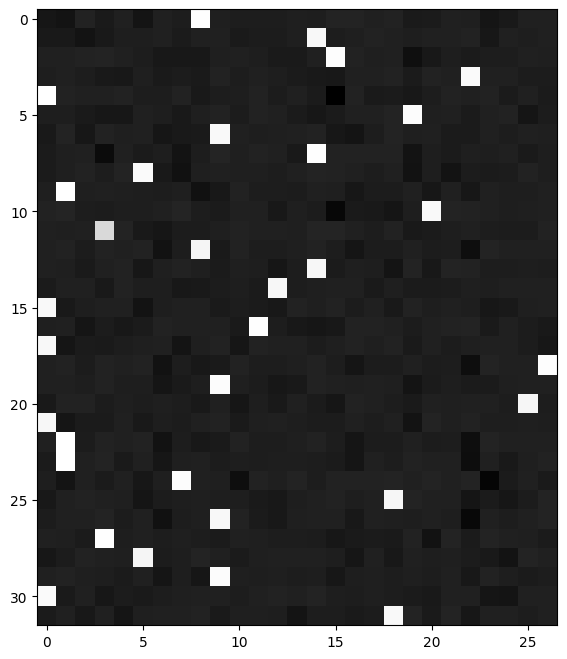

In [196]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [197]:
# So Andrej explained, that cross entropy allows for this nice magical" pushing & pulling correct & incorrect predictions, 
# so in the end they become closer to the value we need, by training.

In [198]:
# #detach experiments
# a = torch.randint(1,10, (3,3))
# b = a.detach()
# print(a)
# b[1,1] = 0
# print(b)
# print(a)
# a[2,2] = 0
# print(b)
# print(a)

In [200]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias

print('max diff:', (hpreact_fast - hpreact).abs().max())


max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [281]:
# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)


display(Math(r'\frac{∂L}{∂γ} = \hat{x_i} * \frac{∂L}{∂y_i}')) 
display(Math(r'\frac{dL}{dβ} = \frac{dL}{dy_i}')) 
display(Math(r'\frac{dL}{d\hat{x_i}} =  \frac{dL}{dy_i} * γ')) 
display(Math(r'\frac{dL}{dσ^2} = \sum_{i=1}^n \frac{dL}{d\hat{x_i}} * \frac{d\hat{x_i}}{dσ^2}'))
display(Math(r'\quad\quad = \frac{dL}{dy_i} * γ * \sum_{i=1}^n (x_i - μ) * -\frac{1}{2}(σ^2 + ε)^\frac{3}{2} ')) 
#
display(Math(r'\frac{∂L}{∂μ} = -\sum_{i=1}^n \frac{dL}{dy_i} * γ * (σ^2 + ε)^{-\frac{1}{2}}')) 
display(Math(r'\frac{∂L}{∂x_i} = \frac{∂L}{∂\hat{x_i}}\frac{∂\hat{x_i}}{∂x_i} + \frac{∂L}{∂μ}\frac{∂μ}{∂x_i} + \frac{∂L}{∂σ^2}\frac{∂σ^2}{∂x_i}')) 

display(Math(r'\quad\quad = \frac{γ*(σ^2 + ε)^{-\frac{1}{2}}}{m} \left[ m\frac{∂L}{∂y_i} - \sum_{j=1}^n \frac{∂L}{∂y_j}'
             r'- \frac{m}{m-1}\hat{x_i}\sum_{j=1}^n\frac{∂L}{∂y_j}\hat{x_i}\right]')) 
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [283]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.7336
  10000/ 200000: 2.1582
  20000/ 200000: 2.3810
  30000/ 200000: 2.4484
  40000/ 200000: 1.9918
  50000/ 200000: 2.3501
  60000/ 200000: 2.3737
  70000/ 200000: 2.0562
  80000/ 200000: 2.3512
  90000/ 200000: 2.1594
 100000/ 200000: 2.0093
 110000/ 200000: 2.3770
 120000/ 200000: 1.9505
 130000/ 200000: 2.4642
 140000/ 200000: 2.2568
 150000/ 200000: 2.1733
 160000/ 200000: 1.9945
 170000/ 200000: 1.8310
 180000/ 200000: 2.0480
 190000/ 200000: 1.8742
